### Resampling methods exercises

Exercises are pretty good. Need to go through them thoroughly. 

##### Question 2(g) -> Probability
Basically how the probability that `j` sample is in bootstrap is $\approx$ 0.635

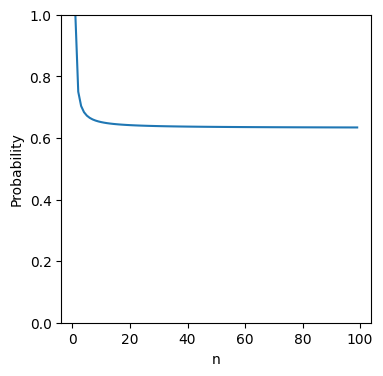

In [2]:
import numpy as np
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt

n = np.arange(1,100)
def f(n) : 
    return 1 - ((1 - 1/n)**n)

y = f(n)
fig, ax = subplots(figsize=(4, 4))
ax.plot(n, y, label='Probability of bootstrap')
ax.set_xlabel('n')
ax.set_ylabel('Probability')
ax.set_ylim(0,1)
plt.show()

In [3]:
# Question 2 (h)
rng = np.random.default_rng(10)
store = np.empty(100000) # stores the result of the bootstrap sample

for i in range(100000):
    sample = rng.choice(n, size=100, replace=True) == 4
    store[i] = np.sum(sample) > 0
    
np.mean(store) # Theoretical convergence. 

0.63799

### Question 5

Test error of `logisitic` regression model using `validation-set` approach

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (cross_validate, KFold, ShuffleSplit)
from ISLP import confusion_table


In [5]:
data = load_data("Default")
data.head()

# Student as an indicator variable.

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [6]:
data_trans = data.replace({"No" : 0, "Yes" : 1})
data_trans.head()

/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_53110/2668108949.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_trans = data.replace({"No" : 0, "Yes" : 1})
/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_53110/2668108949.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data_trans = data.replace({"No" : 0, "Yes" : 1})
/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_53110/2668108949.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [7]:
# Fitting the logistic regression model.
x = MS(data_trans.columns.drop("default")).fit_transform(data_trans)
y = data_trans.loc[:,"default"]
model = sm.GLM(y, x, family=sm.families.Binomial()).fit()
preds = np.where(model.predict(x) > 0.5, 1, 0)
confusion_table(y, preds)

ct = pd.DataFrame(confusion_table(y, preds))
accuracy = (ct.iloc[0,0] + ct.iloc[1,1]) /(ct.sum().sum())
print(f"Accuracy: {accuracy}")

summarize(model).loc[:, "coef"]

Accuracy: 0.9732


intercept    -10.869000
student[1]    -0.646800
balance        0.005700
income         0.000003
Name: coef, dtype: float64

In [8]:
def validation_set(data, random_state, response, test_size) : 
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=random_state)
    design = MS(data.columns.drop([response]))
    x_train = design.fit_transform(data_train)
    x_test = design.transform(data_test)
    y_train = data_train.loc[:,response]
    y_test = data_test.loc[:,response]
    model =  sm.GLM(y_train, x_train, family=sm.families.Binomial()).fit()
    preds = np.where(model.predict(x_test) > 0.5, 1, 0)
    ct = pd.DataFrame(confusion_table(y_test, preds))
    accuracy = (ct.iloc[0,0] + ct.iloc[1,1]) /(ct.sum().sum())
    return accuracy

vals = np.empty(10)
for i in range(0,10): 
    accuracy = validation_set(data_trans, i, "default", test_size = 0.2)
    vals[i] = accuracy
    print(f"Accuracy: {accuracy}")
    
print(f"Mean accuracy: {np.mean(vals)}")  

Accuracy: 0.9715
Accuracy: 0.974
Accuracy: 0.972
Accuracy: 0.98
Accuracy: 0.9745
Accuracy: 0.9745
Accuracy: 0.973
Accuracy: 0.9735
Accuracy: 0.976
Accuracy: 0.9805
Mean accuracy: 0.97495


The test results are variable it feels. But closely in the range of 97.2% - 98.05%. There is performance deprovement but i don't whether that is substantial or not by including student in the dataset.

In [ ]:
# Estimating the standard error of the test error - using bootstrap and standard error. 

def se_validation(data, random_state, response, test_size, column = "std err") : 
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=random_state)
    design = MS(data.columns.drop([response]))
    x_train = design.fit_transform(data_train)
    x_test = design.transform(data_test)
    y_train = data_train.loc[:,response]
    y_test = data_test.loc[:,response]
    model =  sm.GLM(y_train, x_train, family=sm.families.Binomial()).fit()
    std_err = pd.DataFrame(summarize(model).loc[:, column])
    return std_err

def boot_fit(data, response, column = "coef") : 
    design = MS(data.columns.drop([response]))
    x = design.fit_transform(data)
    y = data.loc[:,response]
    model = sm.GLM(y, x, family=sm.families.Binomial()).fit()
    return summarize(model).loc[:, column]

def boot_fu(data, random_state, response, bootstrap_size=100) :
    no_coef = len(data.columns.drop(response)) + 1
    rng = np.random.default_rng(random_state)
    store = np.empty((bootstrap_size, no_coef))
    for i in range(bootstrap_size) : 
        sample = rng.choice(data.index, size=data.shape[0], replace=True)
        data_sample = data.loc[sample]
        se = boot_fit(data_sample,response, column="coef")
        store[i, :] = se.values.flatten()
        if (i % 100 == 0) : 
            print(f"Bootstrap iteration: {i}")
    
    store_names = ['intercept', 'student[1]', 'balance', 'income']
    return pd.DataFrame(store, columns=store_names)

boot = boot_fu(data_trans, 10, "default", bootstrap_size = 1000)

Bootstrap iteration: 0
Bootstrap iteration: 100
Bootstrap iteration: 200
Bootstrap iteration: 300
Bootstrap iteration: 400
Bootstrap iteration: 500
Bootstrap iteration: 600
Bootstrap iteration: 700
Bootstrap iteration: 800
Bootstrap iteration: 900


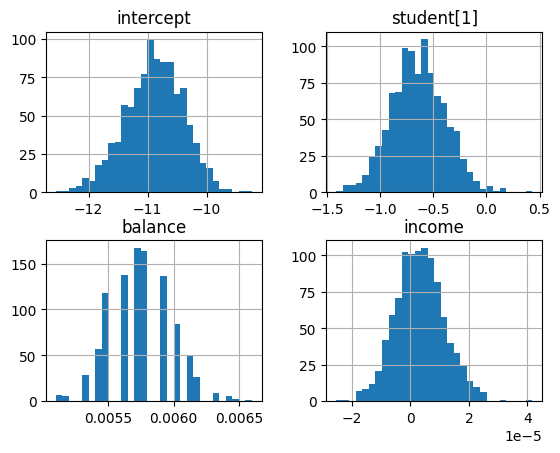

             std err
intercept   0.559000
student[1]  0.267000
balance     0.000000
income      0.000009


intercept     0.490810
student[1]    0.254046
balance       0.000236
income        0.000008
dtype: float64

In [10]:
boot.hist(bins=30)
plt.show()
print(se_validation(data_trans, 10, "default", test_size = 0.2, column="std err"))
boot.std()

There seems to be reduction in standard error using the bootstrap approach. 

### Cross Validation

Approach : 
- Compute quantities using `sm.OLS` & `predict()` in the `for` loop

In [11]:
data = load_data("Weekly")
data.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [12]:
design = MS(["Lag1", "Lag2"])
data_first_removed = data.iloc[1:, :]
x = design.fit_transform(data_first_removed)
y = np.where(data_first_removed.loc[:,"Direction"] == "Up", 1, 0)

model = sm.GLM(y, x, family=sm.families.Binomial()).fit()

# First observation - 0 Index
first_obs = data.iloc[[0], :]
x_new = pd.DataFrame({"intercept" : 1, "Lag1" : first_obs.loc[:,"Lag1"], "Lag2" : first_obs.loc[:,"Lag2"]})
y_new = np.where(first_obs.loc[:,"Direction"] == "Up", 1, 0)
preds = np.where(model.predict(x_new) > 0.5, 1, 0)

# No the observations was not correctly classified.

In [13]:
# Implementing LOOCV
def error(y_test, preds) : 
    if (y_test == preds) : 
        return 0
    else :
        return 1


def LOOCV(data, response, terms, func) : 
    design = MS(terms)
    no_obs = data.shape[0]
    store = np.empty(no_obs)
    for i in range(no_obs) : 
        data_train = data.drop(i) # Did forget this method.
        data_test = data.iloc[[i], :]
        x_train = design.fit_transform(data_train)
        x_test = design.transform(data_test)
        y_train = np.where(data_train.loc[:,response] == "Up", 1, 0)
        y_test = np.where(data_test.loc[:,response] == "Up", 1, 0)
        
        # Computing the posterior probabilities
        model = func(y_train, x_train, family=sm.families.Binomial()).fit()
        preds = np.where(model.predict(x_test) > 0.5, 1, 0)
        
        store[i] = error(y_test, preds)
        if (i % 100 == 0) : 
            print(f"Observation: {i}")
    return print(f"The LOOCV Error is {np.mean(store)}")

LOOCV(data, "Direction", ["Lag1", "Lag2"], sm.GLM)

Observation: 0
Observation: 100
Observation: 200
Observation: 300
Observation: 400
Observation: 500
Observation: 600
Observation: 700
Observation: 800
Observation: 900
Observation: 1000
The LOOCV Error is 0.44995408631772266


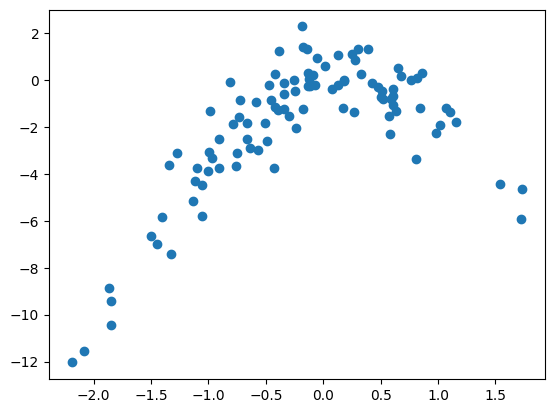

(100,)

In [14]:
rng = np.random.default_rng(10)
x = rng.normal(size=100)
y = x - 2*x**2 + rng.normal(size=100)

# Creating a scatter plot
fig, ax = plt.subplots()
ax.scatter(x, y)
plt.show()

x.shape

The data is being simulated from $Y = x - 2x^2 + Error$

Answers : 
- Here n = 100 and P = 2
- Inverted Parabola : Non linear relationship

In [15]:
def polynomial_loocv(x, y, max_degree=5):
    results = np.empty(max_degree - 1)
    
    for deg in range(2, max_degree + 1):
        n = len(x)
        data = np.column_stack([np.power(x, i) for i in range(deg)])        
        store = np.empty(n)
        
        for j in range(n):
            mask = np.arange(n) != j

            x_train = data[mask]
            y_train = y[mask]
            x_test = data[~mask]
            y_test = y[~mask]
            
            model = sm.OLS(y_train, x_train).fit()
            if(j == 0):
                print(summarize(model))
            pred = model.predict(x_test)
            store[j] = (y_test - pred)**2
            
        results[deg - 2] = np.mean(store)
        
    return results

polynomial_loocv(x,y,max_degree=5)

         coef  std err      t  P>|t|
const -1.5722    0.239 -6.574    0.0
x1     1.9392    0.280  6.914    0.0
         coef  std err       t  P>|t|
const -0.1226    0.134  -0.913  0.363
x1     0.9143    0.140   6.522  0.000
x2    -2.2545    0.119 -18.974  0.000
         coef  std err       t  P>|t|
const -0.0918    0.140  -0.657  0.513
x1     1.0603    0.228   4.656  0.000
x2    -2.3119    0.138 -16.709  0.000
x3    -0.0846    0.104  -0.814  0.417
         coef  std err      t  P>|t|
const  0.0109    0.163  0.067  0.947
x1     0.9229    0.254  3.640  0.000
x2    -2.6874    0.338 -7.961  0.000
x3     0.0104    0.130  0.080  0.936
x4     0.1257    0.103  1.219  0.226


/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_53110/855467774.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  store[j] = (y_test - pred)**2
/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_53110/855467774.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  store[j] = (y_test - pred)**2
/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_53110/855467774.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  store[j] = (y_test - pred

array([5.67128389, 1.15942622, 1.17206401, 1.17264866])

There is a sharp decrease in the MSE from 5.671 to 1.159 and even in the significance only polynomial regression upto $X_2^2$ is significant.

### Question 9

In [16]:
data = load_data("Boston")
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [17]:
# Estimate for population mean
medv = data.loc[:,"medv"]
mu = np.mean(medv) 
mu_se = np.std(medv) / np.sqrt(len(medv)) # Standard error
median = np.median(medv)

print(f"Estimate for population mean: {mu:.2f}")
print(f"Standard error for population mean: {mu_se:.2f}")
print(f"Median: {median:.2f}")


Estimate for population mean: 22.53
Standard error for population mean: 0.41
Median: 21.20


In [18]:
# Estimate standard error using bootstrap
def boot(data, bootstrap_size=1000, seed = 10, func = np.mean, hide = False) : 
    rng = np.random.default_rng(seed)
    store = np.empty(bootstrap_size)
    for i in range(bootstrap_size) : 
        sample = rng.choice(data, size = len(data), replace=True)
        store[i] = func(sample)
        if(hide) : 
            if (i % 100 == 0) : 
                print(f"Bootstrap iteration: {i}")
    return store

results = boot(medv)
print(f"Bootstrap standard error: {np.std(results):.2f}")
print(f"The confidence interval is : {np.mean(results) - 2*np.std(results):.2f}  & {np.mean(results) + 2*np.std(results):.2f}")
print(f"The confidence interval is : {(mu - 2 * mu_se):.2f}  & {(mu + 2 * mu_se):.2f}")

Bootstrap standard error: 0.40
The confidence interval is : 21.74  & 23.34
The confidence interval is : 21.72  & 23.35


Comparatively `BootStrap` Standard Error is almost the same as standard error for population mean, but for confidence interval i think the bounds are narrower. Even if there is no standard error formula for `median` & `10th percentile` we can estimate it using bootstrap.

We can expect some heterogeneity in the distribution of the standard error - quite evident in bootstrap estimates of standard error

In [19]:
# Bootstrap estimate for the median
results = np.std(boot(medv, func=np.median))
print(f"Bootstrap standard error for median: {results:.2f}")

# Bootstrap estimate for the 10th percentile
mu_10 = np.percentile(medv, 10)
results = np.std(boot(medv, func=lambda x: np.percentile(x, 10)))
print(f"Bootstrap standard error for 10th percentile: {results:.2f}")

Bootstrap standard error for median: 0.38
Bootstrap standard error for 10th percentile: 0.49


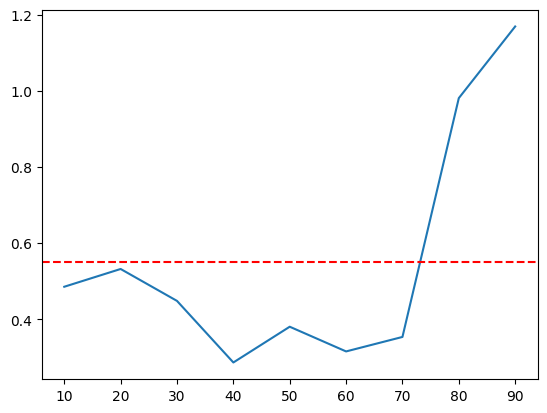

In [20]:
x_vals = np.arange(10, 100, 10)
y = [np.std(boot(medv, func=lambda x: np.percentile(x, i), hide=False)) for i in x_vals]

fig, ax = plt.subplots()
ax.plot(x_vals, y)
ax.axhline(y=np.mean(y), color='r', linestyle='--')
plt.show()